## Installing and importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

## Importing the data

In [2]:
labels = ['normal', 'pneumonia']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels: #This loop goes into the normal and pneumonia directories in each train,test and val directory
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):#This loops through images in each directory
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)#loading the image in the path
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = get_data("/content/drive/MyDrive/train")
test = get_data("/content/drive/MyDrive/test")
val_data = get_data("/content/drive/MyDrive/val")

<ipython-input-2-898774bc05e0>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


## Data exploration

In [5]:
#plotting the number of pneumonia x-ray images and normal X-ray images
train_list = []
for i in train:
    if(i[1] == 0):
        train_list.append("Normal")
    else:
        train_list.append("Pneumonia")

In [13]:
train_list = pd.DataFrame({"class":train_list})
train_list.head()

,class
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal


<Axes: title={'center': 'Number of pneumonia and normal X-ray images in the training set'}, xlabel='class', ylabel='count'>

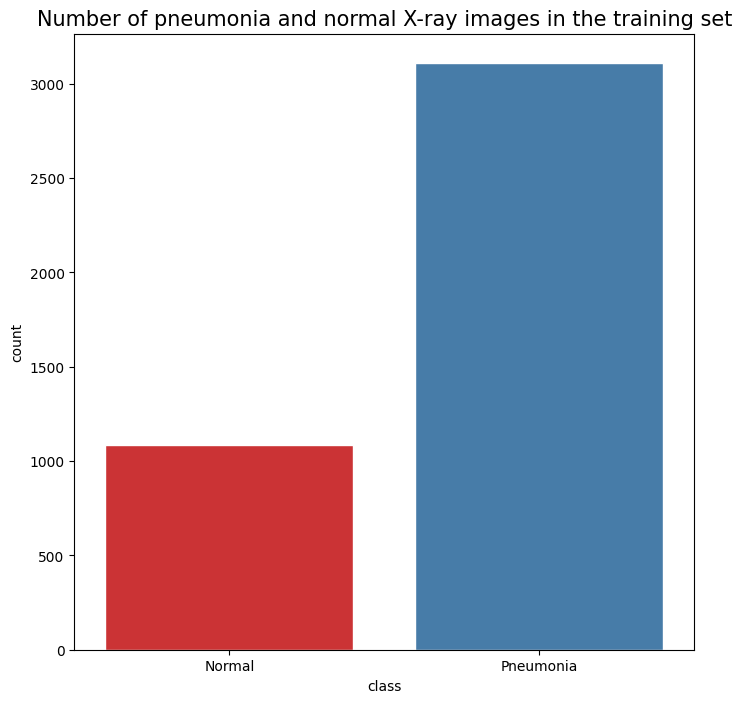

In [14]:
plt.figure(figsize = (8,8))
plt.title("Number of pneumonia and normal X-ray images in the training set", fontsize= 15)
sns.set_style('white')
sns.countplot(x = "class", data = train_list, palette = "Set1" )

From the pictures, we can see that a normal x-ray image is clearer than an X-ray image of a patient with pneumonia   

Text(0.5, 1.0, 'pneumonia')

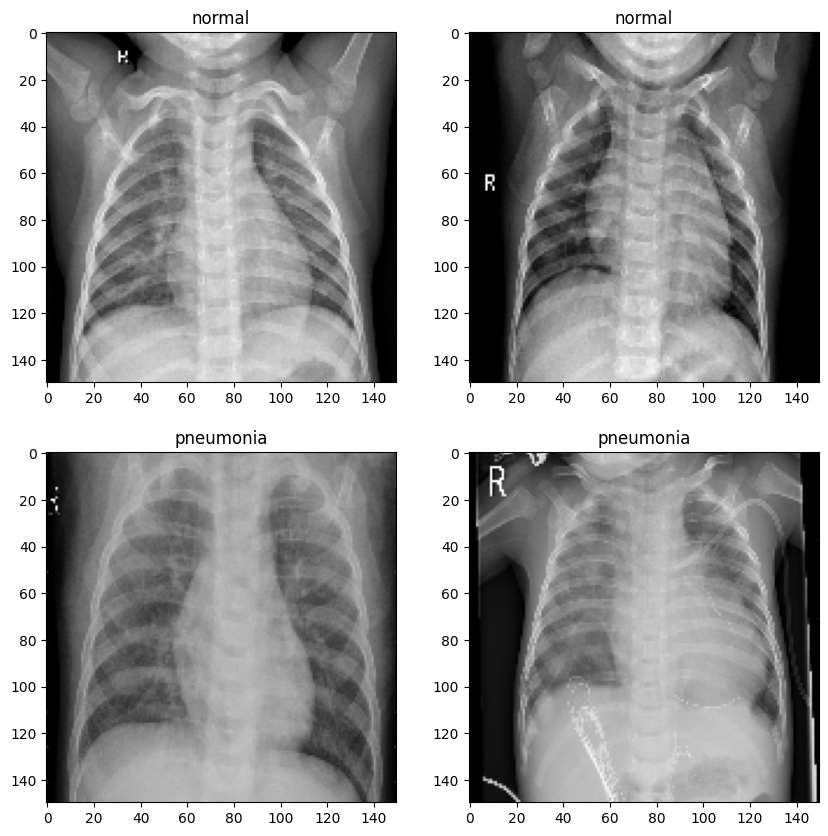

In [7]:
#Plotting multiple figures of pneumonia and normal x-ray images
fig, axs = plt.subplots(2, 2, figsize = (10,10))
#normal X-ray images
axs[0, 0].imshow(train[2][0], cmap='gray')
axs[0, 0].set_title(labels[train[2][1]])

axs[0, 1].imshow(train[1][0], cmap='gray')
axs[0, 1].set_title(labels[train[1][1]])

#pneumonia X-ray images
axs[1, 0].imshow(train[-2][0], cmap='gray')
axs[1, 0].set_title(labels[train[-2][1]])

axs[1, 1].imshow(train[-1][0], cmap='gray')
axs[1, 1].set_title(labels[train[-1][1]])

In [8]:
#Dividing the datasets into the feature and labels
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

print(x_train[-3:-1])
print(y_train[-3:-1])

[array([[215, 212, 202, ..., 189, 204, 217],
       [213, 211, 189, ..., 202, 201, 216],
       [201, 213, 189, ..., 205, 209, 214],
       ...,
       [206, 198, 109, ...,  63, 109, 172],
       [207, 198, 113, ...,  60, 112, 173],
       [209, 199, 112, ...,  59, 110, 174]], dtype=uint8), array([[ 0,  5, 15, ..., 91, 74, 64],
       [ 0,  3, 13, ..., 87, 73, 59],
       [ 0,  3, 15, ..., 73, 65, 57],
       ...,
       [ 0,  0,  0, ..., 12,  4,  0],
       [ 0,  0,  0, ..., 12,  2,  0],
       [ 0,  0,  0, ..., 12,  2,  0]], dtype=uint8)]
[1, 1]


In [9]:
#Normalizing the X data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

###### As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1 which is faster for the CNN to process compared to a range between 0 and 255.

In [10]:
# resize data for the model
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation

Data augmentation is useful to improve the performance and outcomes of machine learning models by forming new and different examples to train datasets. If the dataset in a machine learning model is rich and sufficient, the model performs better and more accurately. The idea is to alter the training data with small transformations to reproduce the variations.  Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, and rotations. Data augmentation allows you to improve your model's performance using your existing dataset by protecting it from overfitting

Data augmentation processes:
- Randomly fliping images vertically
- Randomly rotating some training images by 50 degrees
- Randomly Zooming by 30% some training images
- Randomly shifting images horizontally by 15% of the width
- Randomly shifting images vertically by 20% of the height
- Randomly fliping images horizontally

In [11]:
image_gen = ImageDataGenerator(
        rotation_range = 50,  # randomly rotate images in the range provided
        zoom_range = 0.3, # Randomly zoom image
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

image_gen.fit(x_train)

In [12]:
model = Sequential() #API
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [15]:
#The learning rate of the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [17]:
#Training the model
history = model.fit(image_gen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 12 ,
                    validation_data = image_gen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
132/132 [==============================] - 373s 3s/step - loss: 0.7193 - accuracy: 0.7863 - val_loss: 13.6094 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 2/12
132/132 [==============================] - 363s 3s/step - loss: 0.3395 - accuracy: 0.8485 - val_loss: 17.3198 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 3/12
132/132 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8740
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 323s 2s/step - loss: 0.2951 - accuracy: 0.8740 - val_loss: 11.2499 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 4/12
132/132 [==============================] - 315s 2s/step - loss: 0.2328 - accuracy: 0.9052 - val_loss: 23.7153 - val_accuracy: 0.7433 - lr: 3.0000e-04
Epoch 5/12
132/132 [==============================] - 322s 2s/step - loss: 0.2071 - accuracy: 0.9197 - val_loss: 4.0632 - val_accuracy: 0.7548 - lr: 3.0000e-04
Epoch 6/12
132/132 [===========================

In [18]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 10s 471ms/step - loss: 1.2174 - accuracy: 0.8301
Loss of the model is -  1.2174123525619507
20/20 [==============================] - 11s 553ms/step - loss: 1.2174 - accuracy: 0.8301
Accuracy of the model is -  83.01281929016113 %


### Model Evaluation

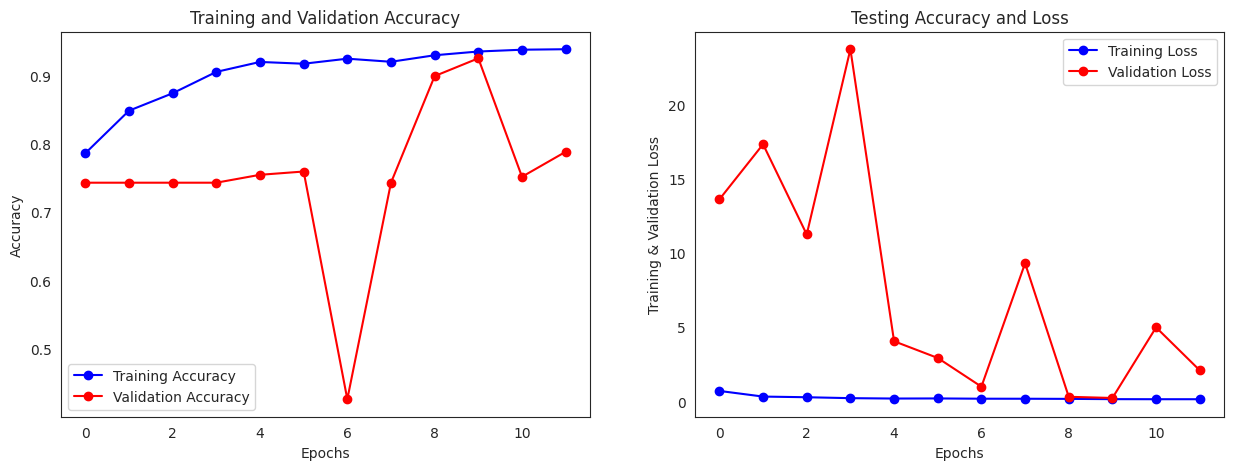

In [60]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy and Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [29]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 12s 587ms/step


array([0.34390122, 0.17142127, 0.2795819 , 0.16493723, 0.33609834,
       0.15398857, 0.27566463, 0.23366989, 0.542766  , 0.99999547,
       0.39269635, 0.44974515, 0.2260659 , 0.5189367 , 0.2318025 ],
      dtype=float32)

In [39]:
#Converting the predictions to 0s and 1s
pred_list = []
for pred in predictions:
  if pred < 0.5:
    pred_list.append(0)
  else:
    pred_list.append(1)
print(pred_list[:15])
print(y_test[:15])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [63]:
print(classification_report(y_test, pred_list, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.98      0.56      0.71       234
   Pneumonia       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



In [61]:
from sklearn.metrics import precision_score,recall_score,f1_score
print('Precision: ',precision_score(y_test, pred_list))
print('Recall: ', recall_score(y_test, pred_list))
print('f1_score: ',f1_score(y_test, pred_list))

Precision:  0.789795918367347
Recall:  0.9923076923076923
f1_score:  0.8795454545454547


In [45]:
cm = confusion_matrix(y_test,pred_list)
cm

array([[131, 103],
       [  3, 387]])

In [46]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

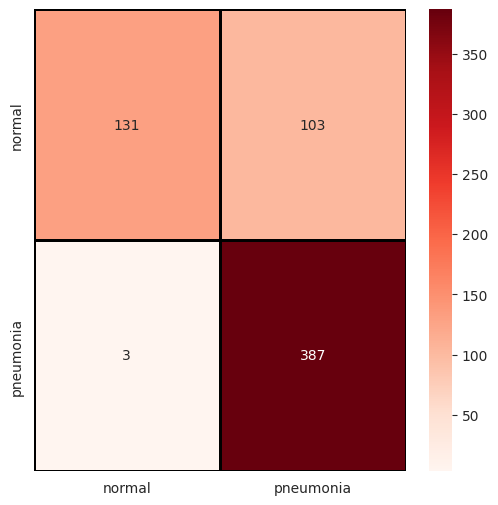

In [64]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [48]:
correct = np.nonzero(pred_list == y_test)[0]
incorrect = np.nonzero(pred_list != y_test)[0]

<ipython-input-50-447d9fb61897>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


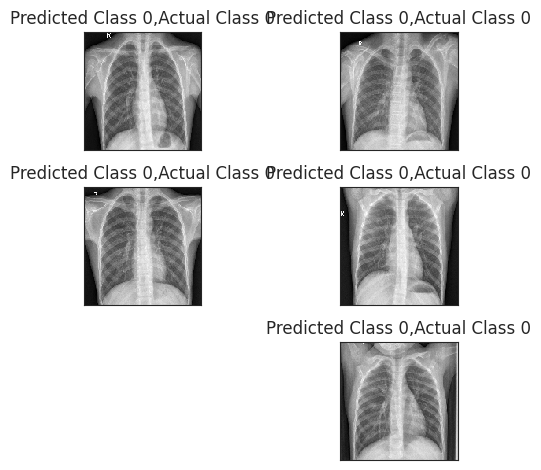

In [50]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(pred_list[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-51-e9872ca2b7f7>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


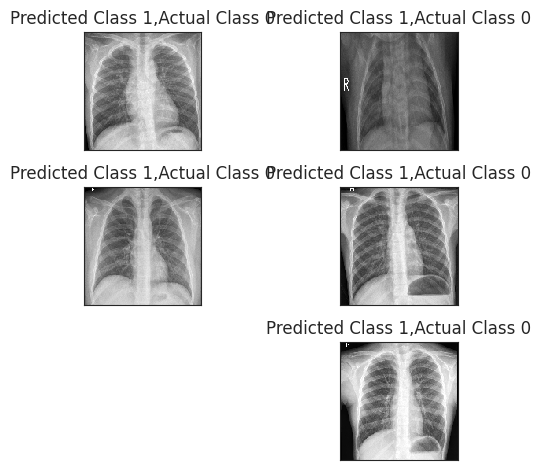

In [51]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(pred_list[c], y_test[c]))
    plt.tight_layout()
    i += 1